# California Housing Prices Prediction Model

Importing the dataset

In [140]:
import pandas as pd
import kagglehub 

# Download the California housing dataset from Kaggle
path = kagglehub.dataset_download("camnugent/california-housing-prices")
# load into pandas dataframe
df = pd.read_csv(path + "/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Data processing

In [141]:
print("Missing values check")
print(df.isnull().sum())

#check number of categories before encoding
df["ocean_proximity"].value_counts() 

Missing values check
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [142]:
# Handling missing values
df["total_bedrooms"].fillna(df["total_bedrooms"].median(), inplace=True)


# Outlier treatment
numerical_cols = ["longitude", "latitude", "housing_median_age", "total_rooms",
                  "total_bedrooms", "population", "households", "median_income"]

for col in numerical_cols:
    df[col] = df[col].clip(lower=df[col].quantile(0.02), upper=df[col].quantile(0.98))


# One-hot encoding for categorical variable
df = pd.get_dummies(df, columns=["ocean_proximity"], drop_first=True)


# Feature engineering
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]
df["income_squared"] = df["median_income"] ** 2



C:\Users\Elfrh\AppData\Local\Temp\ipykernel_15568\1125665281.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["total_bedrooms"].fillna(df["total_bedrooms"].median(), inplace=True)


divide the data and scale it

In [143]:
from sklearn.model_selection import train_test_split
Y = df["median_house_value"]
X = df.drop("median_house_value", axis=1)

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# poly = PolynomialFeatures(degree=2, include_bias=False)
# X_scaled = poly.fit_transform(X_scaled)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

The linear regression model 

In [144]:
import numpy as np

class LinearRegression:
    def __init__(self, lr, epochs):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None

    def dw_batch(self, x, y, y_pred):
        rows = x.shape[0]
        cols = x.shape[1]

        dw = (1 / rows) * np.dot(x.T, (y_pred - y))
        db = (1 / rows) * np.sum(y_pred - y)

        return dw, db
    


    def train(self, x, y):
        
        rows = x.shape[0]
        cols = x.shape[1]

        self.weights = np.zeros(cols)
        self.bias = 0

        for i in range(self.epochs):
            y_pred = self.bias + np.dot(x, self.weights)

            
            dw, db = self.dw_batch(x, y, y_pred)
            
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict(self, x):
        return self.bias + np.dot(x, self.weights)

run the model

In [145]:
model = LinearRegression(lr=0.01, epochs=3000)
model.train(X_train, Y_train.values)
Y_pred = model.predict(X_test)


visualizing performance metrics

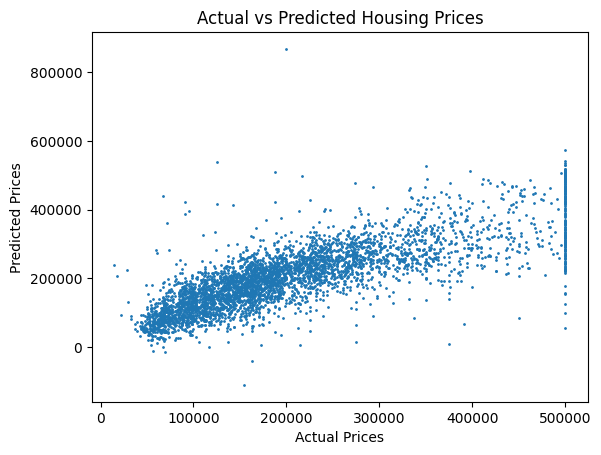

In [146]:
import matplotlib.pyplot as plt
plt.scatter(Y_test, Y_pred, s=1)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Housing Prices")
plt.show()

In [147]:
def MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def RMSE(y_true, y_pred):
    return np.sqrt(MSE(y_true, y_pred))

def R2(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def MAE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

mae = MAE(Y_test.values, Y_pred)
print(f"Mean Absolute Error: {mae}")
mse = MSE(Y_test.values, Y_pred)
print(f"Mean Squared Error: {mse}")
rmse = RMSE(Y_test.values, Y_pred)
print(f"Root Mean Squared Error: {rmse}")
r2 = R2(Y_test.values, Y_pred)
print(f"R^2 Score: {r2}")


Mean Absolute Error: 49372.879289685596
Mean Squared Error: 4943679135.00554
Root Mean Squared Error: 70311.30161649363
R^2 Score: 0.6227376935678538


Regularized Linear Regression

In [148]:
import numpy as np

class RegularizedLinearRegression:
    def __init__(self, lr, epochs, regularization='l1', lambda_=0.01):
        self.lr = lr
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.regularization = regularization
        self.lambda_ = lambda_

    def dw_batch(self, x, y, y_pred):
        rows = x.shape[0]
        cols = x.shape[1]

        dw = (1 / rows) * np.dot(x.T, (y_pred - y))
        db = (1 / rows) * np.sum(y_pred - y)

        return dw, db
    


    def train(self, x, y):
        
        rows = x.shape[0]
        cols = x.shape[1]

        self.weights = np.zeros(cols)
        self.bias = 0

        for i in range(self.epochs):
            y_pred = self.bias + np.dot(x, self.weights)

            
            dw, db = self.dw_batch(x, y, y_pred)
            
            if self.regularization == 'l2':
                dw += 2 * self.lambda_ * self.weights
            elif self.regularization == 'l1':
                dw += self.lambda_ * np.sign(self.weights)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db
    
    def predict(self, x):
        return self.bias + np.dot(x, self.weights)

L1 Regularization - Mean Absolute Error: 48997.237976511664
L2 Regularization - Mean Absolute Error: 49963.90455693024
L1 Regularization - Mean Squared Error: 4796205246.9314575
L2 Regularization - Mean Squared Error: 4889473258.354538
L1 Regularization - Root Mean Squared Error: 69254.64061657859
L2 Regularization - Root Mean Squared Error: 69924.76856132266
Non-Regularized Linear Regression - R^2 Score: 0.6227376935678538
L1 Regularization - R^2 Score: 0.633991728798294
L2 Regularization - R^2 Score: 0.6268742553246092


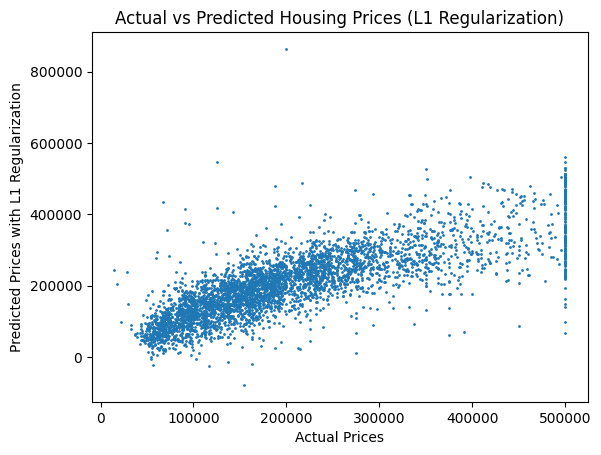

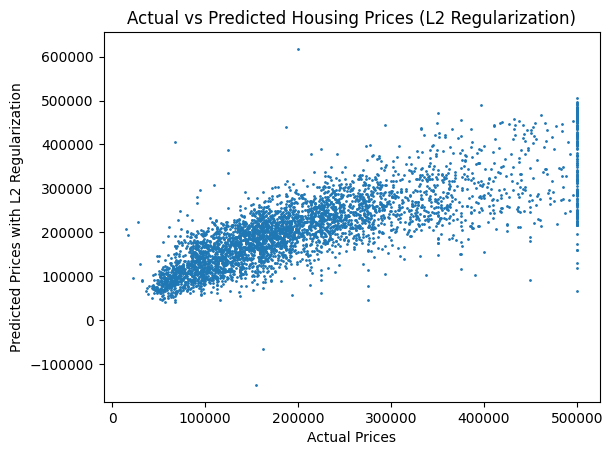

In [152]:
model1 = RegularizedLinearRegression(lr=0.1, epochs=10000, regularization='l1', lambda_=0.1)
model1.train(X_train, Y_train.values)
model2 = RegularizedLinearRegression(lr=0.1, epochs=10000, regularization='l2', lambda_=0.1)
model2.train(X_train, Y_train.values)

Y_pred_l1 = model1.predict(X_test)
Y_pred_l2 = model2.predict(X_test)

mae_l1 = MAE(Y_test.values, Y_pred_l1)
print(f"L1 Regularization - Mean Absolute Error: {mae_l1}")
mae_l2 = MAE(Y_test.values, Y_pred_l2)
print(f"L2 Regularization - Mean Absolute Error: {mae_l2}")

mse_l1 = MSE(Y_test.values, Y_pred_l1)
print(f"L1 Regularization - Mean Squared Error: {mse_l1}")
mse_l2 = MSE(Y_test.values, Y_pred_l2)
print(f"L2 Regularization - Mean Squared Error: {mse_l2}")

rmse_l1 = RMSE(Y_test.values, Y_pred_l1)
print(f"L1 Regularization - Root Mean Squared Error: {rmse_l1}")
rmse_l2 = RMSE(Y_test.values, Y_pred_l2)
print(f"L2 Regularization - Root Mean Squared Error: {rmse_l2}")
r2_l1 = R2(Y_test.values, Y_pred_l1)
print(f"Non-Regularized Linear Regression - R^2 Score: {r2}")
print(f"L1 Regularization - R^2 Score: {r2_l1}")
r2_l2 = R2(Y_test.values, Y_pred_l2)
print(f"L2 Regularization - R^2 Score: {r2_l2}")


plt.scatter(Y_test, Y_pred_l1, s=1)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices with L1 Regularization")
plt.title("Actual vs Predicted Housing Prices (L1 Regularization)")
plt.show()


plt.scatter(Y_test, Y_pred_l2, s=1)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices with L2 Regularization")
plt.title("Actual vs Predicted Housing Prices (L2 Regularization)")
plt.show()